In [1]:
import logging
import multiprocessing
import os
from datetime import datetime

In [3]:
# !rm -rf ./logs
# !rm -rf ./frames

In [4]:
# Configure logging
log_dir = "./logs"
os.makedirs(log_dir, exist_ok=True)

logging.basicConfig(
    filename=os.path.join(log_dir, "main_log.txt"),
    filemode="w",
    format="%(asctime)s - %(name)s - %(levelname)s - \n%(message)s \n",
    level=logging.INFO,
)

In [5]:
main_logger = logging.getLogger(__name__)
main_logger.info("Main pipeline process started.")

In [6]:
def setup_logger(log_folder):
    # Get the current process ID using multiprocessing
    process_id = multiprocessing.current_process().pid
    # Create a timestamp string for the filename
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

    os.makedirs(log_folder, exist_ok=True)
    log_filename = os.path.join(
        log_folder,
        f"log_{timestamp}_PID{process_id}.txt",
    )

    # Create a logger for the process
    logger_name = f"process_{process_id}"
    logger = logging.getLogger(logger_name)
    logger.setLevel(logging.INFO)

    # Prevent log messages from being propagated to ancestor loggers
    logger.propagate = False

    # Check if the logger already has handlers to avoid adding multiple handlers
    if not logger.handlers:
        # Create a file handler for the process-specific log file
        file_handler = logging.FileHandler(log_filename)
        file_handler.setLevel(logging.INFO)

        # Create a formatter and set it for the file handler
        formatter = logging.Formatter(
            "%(asctime)s - %(name)s - %(levelname)s - \n%(message)s \n"
        )
        file_handler.setFormatter(formatter)

        # Add the file handler to the logger
        logger.addHandler(file_handler)

    return logger

# Playing with OpenAI API

In [ ]:
import os

import openai
from dotenv import load_dotenv

In [44]:
load_dotenv()  # take environment variables from .env.

openai_api_key = os.getenv("OPENAI_API_KEY")

openai.api_key = openai_api_key  # Set API key

In [45]:
prompt = "Tell me about 'temperature' parameter in the openai API"

response = openai.chat.completions.create(
    model="gpt-4o",
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": prompt},
    ],
    temperature=0.2,
    max_tokens=200,
)

print(response.choices[0].message.content)

In the OpenAI API, the `temperature` parameter is used to control the randomness of the model's output. It is a floating-point value that typically ranges from 0 to 1, although values slightly above 1 can also be used. Here's how it works:

- **Low Temperature (e.g., 0.1):** The model's output will be more deterministic and focused. It will choose the most likely next word or token, leading to more predictable and repetitive responses. This is useful when you want a more precise and reliable answer.

- **High Temperature (e.g., 0.9):** The model's output will be more random and creative. It will have a higher chance of choosing less likely words or tokens, which can lead to more varied and creative responses. This is useful when you want the model to generate more diverse or imaginative content.

- **Temperature of 0:** This setting makes the model deterministic, meaning it will always produce the same output for


# 1. Video processing

In [7]:
import logging
import os
from typing import Dict, List

from scenedetect import SceneManager, VideoManager
from scenedetect.detectors import ContentDetector, ThresholdDetector

In [8]:
class VideoProcessor:
    """
    Handles video loading and scene detection using PySceneDetect.
    """

    def __init__(
        self, video_path: str, detector_type: str = "content", threshold: float = None
    ):
        # Obtain a logger for this class/module
        self.logger = logging.getLogger("VideoProcessor")

        if not os.path.exists(video_path):
            self.logger.error(f"Video file not found: {video_path}")
            raise FileNotFoundError(f"Video file not found: {video_path}")

        self.video_path = video_path
        self.scene_list = []
        self.detector_type = detector_type.lower()
        self.threshold = threshold

    def detect_scenes(self) -> List[Dict]:
        """
        Detects scenes in the video using the specified detection method.

        Returns:
            List[Dict]: A list of dictionaries containing scene metadata.
        """
        video_manager = VideoManager([self.video_path])
        scene_manager = SceneManager()

        # Select the detector based on the specified type
        if self.detector_type == "content":
            # Effective at detecting cuts where the visual content changes abruptly.
            # Suitable for a wide variety of videos with diverse content.
            # Less sensitive to small changes in lighting or noise, as it focuses on significant content differences.
            threshold_value = (
                self.threshold if self.threshold is not None else 27.0
            )  # Default value
            detector = ContentDetector(threshold=threshold_value)
            self.logger.info(f"Using ContentDetector with threshold={threshold_value}")
        elif self.detector_type == "threshold":
            # Detects scene changes based on changes in the average luminance (brightness) of frames.
            # Monitors the brightness level of frames to identify transitions.
            threshold_value = (
                self.threshold if self.threshold is not None else 12.0
            )  # Default value
            detector = ThresholdDetector(threshold=threshold_value)
            self.logger.info(
                f"Using ThresholdDetector with threshold={threshold_value}"
            )
        else:
            self.logger.error(f"Unsupported detector type: {self.detector_type}")
            raise ValueError(f"Unsupported detector type: {self.detector_type}")

        scene_manager.add_detector(detector)
        video_manager.set_downscale_factor()

        try:
            video_manager.start()
            scene_manager.detect_scenes(frame_source=video_manager)
            scene_list = scene_manager.get_scene_list()

            # If no scenes are detected, log a warning
            if not scene_list:
                self.logger.warning("No scenes were detected in the video.")

            self.scene_list = [
                {
                    "start_timecode": start.get_timecode(),
                    "end_timecode": end.get_timecode(),
                    "start_seconds": start.get_seconds(),
                    "end_seconds": end.get_seconds(),
                    "start_frame": start.get_frames(),
                    "end_frame": end.get_frames(),
                    "cut_scene_number": idx + 1,
                }
                for idx, (start, end) in enumerate(scene_list)
            ]

            self.logger.info(
                f"Detected {len(self.scene_list)} scenes using {self.detector_type} detector."
            )

            return self.scene_list

        except Exception as e:
            self.logger.error(f"Error during scene detection: {e}")
            raise

        finally:
            video_manager.release()
            self.logger.info("VideoManager resources have been released.")

In [ ]:
# video_path = "./input_data/example.mp4"

# processor = VideoProcessor(video_path, detector_type="content", threshold=27.0)

# scenes = processor.detect_scenes()

# print(f"Detected {len(scenes)} scenes.")

# 2. Extracting frames from cut scenes

In [9]:
import logging
import os
from typing import Dict, List

import cv2

In [10]:
class FrameExtractor:
    """
    Extracts frames corresponding to each scene from the video.
    """

    def __init__(
        self,
        video_path: str,
        scenes: List[Dict],
        output_dir: str = "frames",
        frames_per_scene: int = 1,
    ):
        self.logger = logging.getLogger("FrameExtractor")
        self.video_path = video_path
        self.scenes = scenes
        self.output_dir = output_dir
        self.frames_per_scene = (
            frames_per_scene  # Number of frames to extract per scene
        )

        # Create output directory if it doesn't exist
        os.makedirs(self.output_dir, exist_ok=True)

    def extract_frames(self) -> List[Dict]:
        """
        Extracts frames for each scene and stores them alongside the metadata.

        Returns:
            List[Dict]: Updated scene metadata including frame file paths.
        """
        self.logger.info("Starting frame extraction.")
        cap = cv2.VideoCapture(self.video_path)

        if not cap.isOpened():
            self.logger.error(f"Failed to open video file: {self.video_path}")
            raise IOError(f"Failed to open video file: {self.video_path}")

        frame_data_list = []

        for scene in self.scenes:
            scene_number = scene["cut_scene_number"]
            start_frame = int(scene["start_frame"])
            end_frame = int(scene["end_frame"])
            total_frames = end_frame - start_frame + 1

            # self.logger.debug(
            #     f"Extracting frames for Scene {scene_number}: Frames {start_frame} to {end_frame}"
            # )

            # Determine frame indices to extract
            if self.frames_per_scene >= total_frames:
                # Extract all frames in the scene
                frame_indices = list(range(start_frame, end_frame + 1))
            else:
                # Evenly distribute frames across the scene
                frame_indices = self._get_frame_indices(
                    start_frame, end_frame, self.frames_per_scene
                )

            frame_paths = []

            for frame_idx in frame_indices:
                cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
                ret, frame = cap.read()

                if not ret:
                    self.logger.warning(
                        f"Failed to read frame {frame_idx} for Scene {scene_number}"
                    )
                    continue

                frame_filename = f"scene_{scene_number}_frame_{frame_idx}.jpg"
                frame_path = os.path.join(self.output_dir, frame_filename)
                cv2.imwrite(frame_path, frame)
                frame_paths.append(frame_path)

            # Update scene metadata with frame paths
            scene["frame_paths"] = frame_paths
            frame_data_list.append(scene)

            self.logger.info(
                f"Extracted {len(frame_paths)} frames for Scene {scene_number}"
            )

        cap.release()
        self.logger.info("Frame extraction completed.")

        return frame_data_list

    def _get_frame_indices(
        self, start_frame: int, end_frame: int, num_frames: int
    ) -> List[int]:
        """
        Evenly distributes frame indices across the scene.

        Args:
            start_frame (int): Starting frame of the scene.
            end_frame (int): Ending frame of the scene.
            num_frames (int): Number of frames to extract.

        Returns:
            List[int]: List of frame indices to extract.
        """
        total_frames = end_frame - start_frame + 1
        interval = total_frames / num_frames
        frame_indices = [int(start_frame + i * interval) for i in range(num_frames)]
        return frame_indices

In [11]:
# video_path = "./input_data/example.mp4"
video_path = "./input_data/minecraft.mp4"

processor = VideoProcessor(video_path, detector_type="content", threshold=27.0)

scenes = processor.detect_scenes()

print(f"Detected {len(scenes)} scenes.")

Detected 34 scenes.


In [12]:
# Assuming you have the scenes from the VideoProcessor
# Create an instance of FrameExtractor
frame_extractor = FrameExtractor(
    video_path=video_path,
    scenes=scenes,
    output_dir="frames",
    frames_per_scene=1,  # Adjust as needed
)

# Extract frames
scenes_with_frames = frame_extractor.extract_frames()

# 3. Image captioning

Images are made available to the model in two main ways: by passing a link to the image or by passing the base64 encoded image directly in the request. Images can be passed in the `user` messages.

In [13]:
import base64
import logging
import os
from typing import Dict, List

import openai
from dotenv import load_dotenv

In [14]:
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

In [7]:
# load_dotenv()  # take environment variables from .env.

# openai_api_key = os.getenv("OPENAI_API_KEY")

# openai.api_key = openai_api_key  # Set API key

In [ ]:
# image_path = "./input_data/cat.jpeg"

# # Getting the base64 string
# base64_image = encode_image(image_path)

# response = openai.chat.completions.create(
#     model="gpt-4o",
#     messages=[
#         {"role": "system", "content": "You are an assistant for image captioning."},
#         {
#             "role": "user",
#             "content": [
#                 {
#                     "type": "text",
#                     "text": "What is in this image?",
#                 },
#                 {
#                     "type": "image_url",
#                     "image_url": {
#                         "url": f"data:image/jpeg;base64,{base64_image}",
#                         "detail": "high",
#                     },
#                 },
#             ],
#         },
#     ],
#     max_tokens=300,
# )

# print(response.choices[0].message.content)

In [15]:
def encode_image(image_path: str) -> str:
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")


def generate_caption_one_image(
    image_path: str, openai_api_key: str, logger: logging.Logger
) -> str:
    # # For debugging and testing
    # logger.info(f"Generated caption for frame {image_path}")
    # return {"frame_path": image_path, "caption": None}

    openai.api_key = openai_api_key  # Set API key in the process

    # Getting the base64 string
    base64_image = encode_image(image_path)

    try:
        response = openai.chat.completions.create(
            model="gpt-4o",
            messages=[
                {
                    "role": "system",
                    "content": "You are an assistant for image captioning.",
                },
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "text",
                            "text": "What is in this image?",  # Describe what you see in the picture, noting down specific details
                        },
                        {
                            "type": "image_url",
                            "image_url": {
                                "url": f"data:image/jpeg;base64,{base64_image}",
                                "detail": "high",
                            },
                        },
                    ],
                },
            ],
            max_tokens=300,
        )

        logger.info(f"Generated caption for frame {image_path}")

        return {
            "frame_path": image_path,
            "caption": response.choices[0].message.content,
        }

    except openai.RateLimitError as e:
        logger.error(f"Rate limit error: {e}")
        # Handle rate limit error (e.g., retry after some time)
        return {"frame_path": image_path, "caption": None}

    except Exception as e:
        logger.error(f"Error during OpenAI API call for frame {image_path}: {e}")
        return {"frame_path": image_path, "caption": None}


def generate_caption_one_cut_scene(scene: dict, openai_api_key: str) -> dict:
    log_folder = "./logs/ImageCaptioningAgent_logs"
    os.makedirs(log_folder, exist_ok=True)
    logger = setup_logger(log_folder)

    scene_number = scene["cut_scene_number"]
    frame_paths = scene.get("frame_paths", [])

    if not frame_paths:
        logger.warning(
            f"No frames found for Scene {scene_number}. Skipping captioning."
        )
        scene["captions"] = []
        return scene

    logger.info(
        f"Generating captions for Scene {scene_number} with {len(frame_paths)} frames."
    )

    caption_list = []
    for frame_path in frame_paths:
        frame_caption = generate_caption_one_image(frame_path, openai_api_key, logger)
        caption_list.append(frame_caption)

    # Update scene metadata with captions
    scene["captions"] = caption_list

    logger.info(f"Completed caption generation for Scene {scene_number}.")

    return scene

In [16]:
class ImageCaptioningAgent:
    """
    Generates captions for frames extracted from scenes.
    """

    def __init__(self, num_processes: int, scenes: List[Dict], openai_api_key: str):
        self.logger = logging.getLogger("ImageCaptioningAgent")
        self.num_processes = num_processes
        self.scenes = scenes
        self.openai_api_key = openai_api_key

    def generate_captions(self) -> List[Dict]:
        """
        Generates captions for each frame in the scenes.

        Returns:
            List[Dict]: Updated scene metadata including captions.
        """
        self.logger.info("Starting image captioning for scenes.")

        # Prepare chunks for multiprocessing
        chunks = [(scene, self.openai_api_key) for scene in self.scenes]

        with multiprocessing.Pool(processes=self.num_processes) as pool:
            results = pool.starmap(generate_caption_one_cut_scene, chunks)

        self.logger.info("Image captioning for all scenes completed.")

        return results

In [17]:
scenes_with_frames

[{'start_timecode': '00:00:00.000',
  'end_timecode': '00:00:01.458',
  'start_seconds': 0.0,
  'end_seconds': 1.458333325777202,
  'start_frame': 0,
  'end_frame': 35,
  'cut_scene_number': 1,
  'frame_paths': ['frames/scene_1_frame_0.jpg']},
 {'start_timecode': '00:00:01.458',
  'end_timecode': '00:00:08.333',
  'start_seconds': 1.458333325777202,
  'end_seconds': 8.33333329015544,
  'start_frame': 35,
  'end_frame': 200,
  'cut_scene_number': 2,
  'frame_paths': ['frames/scene_2_frame_35.jpg']},
 {'start_timecode': '00:00:08.333',
  'end_timecode': '00:00:10.250',
  'start_seconds': 8.33333329015544,
  'end_seconds': 10.249999946891192,
  'start_frame': 200,
  'end_frame': 246,
  'cut_scene_number': 3,
  'frame_paths': ['frames/scene_3_frame_200.jpg']},
 {'start_timecode': '00:00:10.250',
  'end_timecode': '00:00:11.708',
  'start_seconds': 10.249999946891192,
  'end_seconds': 11.708333272668394,
  'start_frame': 246,
  'end_frame': 281,
  'cut_scene_number': 4,
  'frame_paths': ['f

In [18]:
load_dotenv()  # take environment variables from .env.

openai_api_key = os.getenv("OPENAI_API_KEY")

In [81]:
# !rm -rf ./logs/ImageCaptioningAgent_logs

In [19]:
num_processes = int(0.7 * multiprocessing.cpu_count())
print(f"Utilizing num_processes = {num_processes}")

Utilizing num_processes = 28


In [20]:
image_captioning_agent = ImageCaptioningAgent(
    num_processes=num_processes,
    scenes=scenes_with_frames,
    openai_api_key=openai_api_key,
)
scenes_with_captions = image_captioning_agent.generate_captions()

In [21]:
scenes_with_captions

[{'start_timecode': '00:00:00.000',
  'end_timecode': '00:00:01.458',
  'start_seconds': 0.0,
  'end_seconds': 1.458333325777202,
  'start_frame': 0,
  'end_frame': 35,
  'cut_scene_number': 1,
  'frame_paths': ['frames/scene_1_frame_0.jpg'],
  'captions': [{'frame_path': 'frames/scene_1_frame_0.jpg',
    'caption': 'The image shows a digital interface featuring a block with a rotation option highlighted. Above the block, text reads "World record 1:56," suggesting a recorded time achievement.'}]},
 {'start_timecode': '00:00:01.458',
  'end_timecode': '00:00:08.333',
  'start_seconds': 1.458333325777202,
  'end_seconds': 8.33333329015544,
  'start_frame': 35,
  'end_frame': 200,
  'cut_scene_number': 2,
  'frame_paths': ['frames/scene_2_frame_35.jpg'],
  'captions': [{'frame_path': 'frames/scene_2_frame_35.jpg',
    'caption': 'The image shows a digital interface with a label that reads "World record 1:56" at the top. Below, there is a square area labeled "100%" with a cursor pointing t

In [ ]:
# import pickle

# dir_to_save = "./results"
# os.makedirs(dir_to_save, exist_ok=True)

# path_to_save = os.path.join(dir_to_save, "scenes_with_captions.pkl")

# with open(path_to_save, "wb") as f:
#     pickle.dump(scenes_with_captions, f)

In [86]:
# scenes_with_captions[7]

In [87]:
# from IPython.display import Image, display

# # Path to your image file
# image_path = scenes_with_captions[7]["captions"][0]["frame_path"]

# # Display the image
# display(Image(filename=image_path))

In [88]:
# print(scenes_with_captions[7]["captions"][0]["caption"])

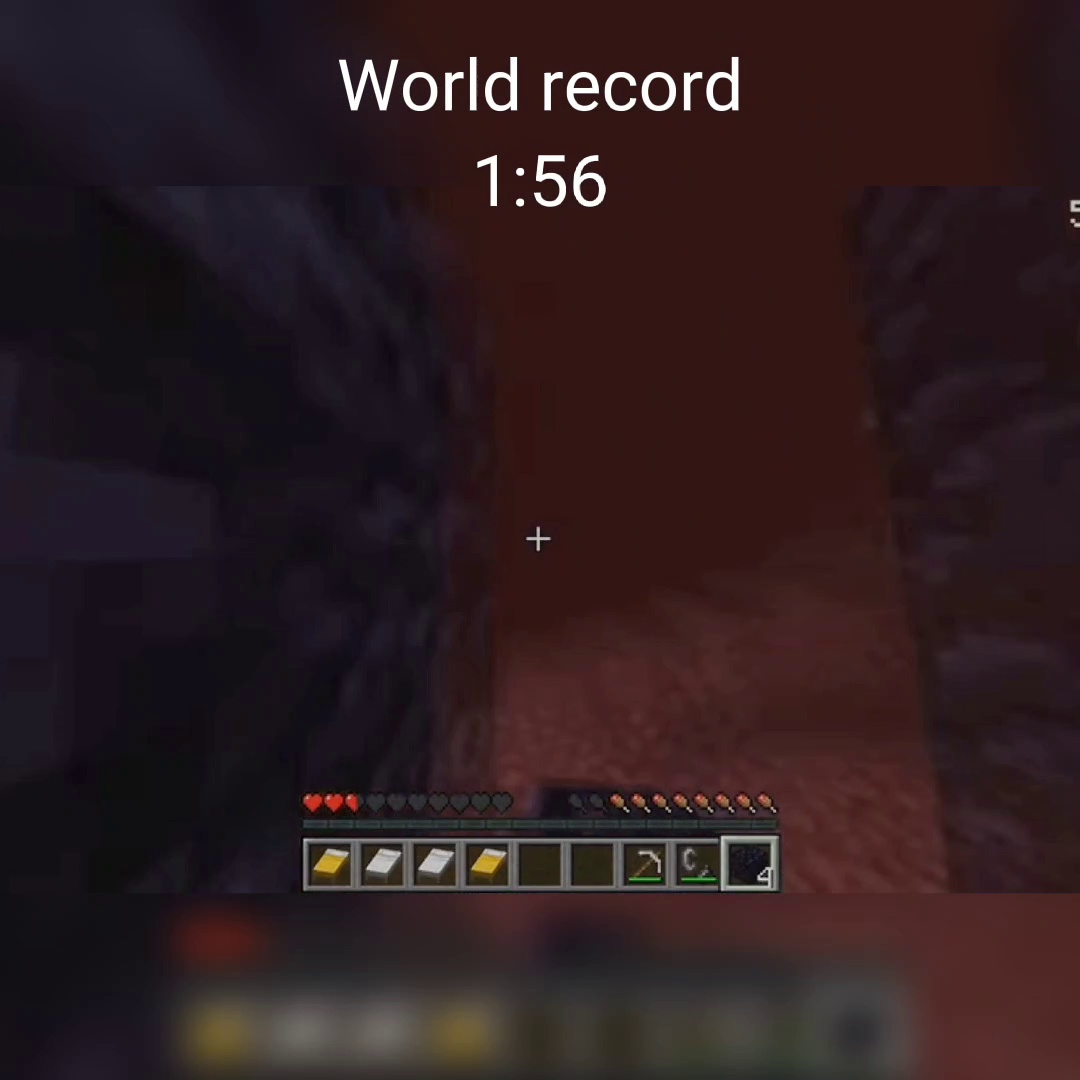

In [23]:
from IPython.display import Image, display

cut_scene_number = 20

# Path to your image file
image_path = scenes_with_captions[cut_scene_number]["captions"][0]["frame_path"]

# Display the image
display(Image(filename=image_path))

In [24]:
print(scenes_with_captions[cut_scene_number]["captions"][0]["caption"])

The image shows a screenshot from the video game Minecraft. The player's interface is visible with tools and items in the hotbar, including a pickaxe and beds. The scene appears to be set in the Nether, a dimension in Minecraft. Text at the top reads "World record 1:56," suggesting a speedrunning achievement or attempt.


# My handmade labeling 

Preparing `json` file for comfortable labeling

In [ ]:
import copy
import json
import pickle

import numpy as np

In [85]:
with open("./results/scenes_with_captions.pkl", "rb") as f:
    scenes_with_captions = pickle.load(f)

In [ ]:
scenes_with_handmade_labels = []

# Create a deep copy of the original list to avoid changes in it
scenes_with_captions_copied = copy.deepcopy(scenes_with_captions)
for scene in scenes_with_captions_copied:
    scene_number = scene["cut_scene_number"]
    captions = scene.get("captions", [])

    if not captions:
        print(f"No captions found for Scene {scene_number}. Skipping.")
    else:
        processed_captions = []
        for caption in captions:
            caption["setting"] = ""
            processed_captions.append(caption)

        scene["captions"] = processed_captions

    scenes_with_handmade_labels.append(scene)


In [45]:
dir_path = "./results"
json_file_path = os.path.join(dir_path, "scenes_with_handmade_labels.json")

with open(json_file_path, "w", encoding="utf-8") as json_file:
    json.dump(scenes_with_handmade_labels, json_file, ensure_ascii=False, indent=4)

Loading `possible_settings`

In [82]:
with open(
    "./input_data/possible_settings_minecraft_processed.json", "r", encoding="utf-8"
) as json_file:
    possible_settings_dict = json.load(json_file)

In [83]:
possible_settings = list(possible_settings_dict.keys())
len(possible_settings)

9

In [84]:
possible_settings

['Game Menu: Loading Screen',
 'Game Menu: Pause Menu',
 'Game Menu: Inventory Screen',
 'Overworld: Plains',
 'Overworld: Forest',
 'Overworld: Village',
 'Nether: Nether Wastes',
 'End: The End',
 'Other: Nether Portal']

In [119]:
with open(
    "./results/scenes_with_handmade_labels.json", "r", encoding="utf-8"
) as json_file:
    scenes_with_handmade_labels = json.load(json_file)

In [ ]:
# scenes_with_handmade_labels_lower = []
# for scene in scenes_with_handmade_labels:
#     captions = scene.get("captions", [])
#     if not captions:
#         print(f"No captions found for Scene {scene_number}. Skipping.")
#     else:
#         processed_captions = []
#         for caption in captions:
#             caption["setting"] = caption["setting"].lower()
#             processed_captions.append(caption)

#         scene["captions"] = processed_captions

#     scenes_with_handmade_labels_lower.append(scene)


# dir_path = "./results"
# json_file_path = os.path.join(dir_path, "scenes_with_handmade_labels.json")

# with open(json_file_path, "w", encoding="utf-8") as json_file:
#     json.dump(
#         scenes_with_handmade_labels_lower, json_file, ensure_ascii=False, indent=4
#     )

In [69]:
scenes_with_handmade_labels_copied = copy.deepcopy(scenes_with_handmade_labels)

In [104]:
handmade_labels_list = [
    caption["setting"].lower()
    for scene in scenes_with_handmade_labels_copied
    for caption in scene["captions"]
]
handmade_labels_list

['game menu: loading screen',
 'game menu: loading screen',
 'game menu: pause menu',
 'game menu: pause menu',
 'overworld: plains',
 'overworld: village',
 'overworld: village',
 'overworld: village',
 'overworld: village',
 'overworld: village',
 'overworld: village',
 'overworld: village',
 'overworld: village',
 'overworld: forest',
 'game menu: inventory screen',
 'other: nether portal',
 'nether: nether wastes',
 'nether: nether wastes',
 'nether: nether wastes',
 'nether: nether wastes',
 'nether: nether wastes',
 'other: nether portal',
 'game menu: loading screen',
 'end: the end',
 'end: the end',
 'end: the end',
 'end: the end',
 'end: the end',
 'end: the end',
 'end: the end',
 'end: the end',
 'end: the end',
 'end: the end',
 'game menu: pause menu']

In [ ]:
assert (
    np.array([item in possible_settings for item in handmade_labels_list]).all()
), "Handmade labeling contains labels outside of the given 'possible_settings' list."

In [80]:
scenes_with_handmade_labels_copied

[{'start_timecode': '00:00:00.000',
  'end_timecode': '00:00:01.458',
  'start_seconds': 0.0,
  'end_seconds': 1.458333325777202,
  'start_frame': 0,
  'end_frame': 35,
  'cut_scene_number': 1,
  'frame_paths': ['frames/scene_1_frame_0.jpg'],
  'captions': [{'frame_path': 'frames/scene_1_frame_0.jpg',
    'caption': 'The image shows a digital interface featuring a block with a rotation option highlighted. Above the block, text reads "World record 1:56," suggesting a recorded time achievement.',
    'setting': 'Game Menu: Loading Screen'}]},
 {'start_timecode': '00:00:01.458',
  'end_timecode': '00:00:08.333',
  'start_seconds': 1.458333325777202,
  'end_seconds': 8.33333329015544,
  'start_frame': 35,
  'end_frame': 200,
  'cut_scene_number': 2,
  'frame_paths': ['frames/scene_2_frame_35.jpg'],
  'captions': [{'frame_path': 'frames/scene_2_frame_35.jpg',
    'caption': 'The image shows a digital interface with a label that reads "World record 1:56" at the top. Below, there is a square 

# 4. Setting classification

In [87]:
def classify_frame_setting(
    frame_path: str,
    caption: str,
    possible_settings: List[str],
    openai_api_key: str,
    logger: logging.Logger,
) -> str:
    openai.api_key = openai_api_key  # Set API key in the process

    prompt = (
        f"Based on the following description, classify the setting of the scene into one of the predefined categories.\n\n"
        f"Description: {caption}\n\n"
        f"Possible settings: {', '.join(possible_settings)}\n\n"
        f"Answer format: Only provide the setting name from the list above."
    )
    # Notice specific details and objects in the description classify the setting of the scene into one of the predefined categories
    # thinking about which of these categories most likely will have such objects.
    try:
        response = openai.chat.completions.create(
            model="gpt-4o",
            messages=[
                {
                    "role": "system",
                    "content": "You are an assistant that classifies video frames into predefined settings.",
                },
                {"role": "user", "content": prompt},
            ],
            max_tokens=10,
            n=1,
            stop=None,
            temperature=0.0,
        )

        setting = response.choices[0].message.content.strip().lower()

        # Validate the setting
        if setting not in [s.lower() for s in possible_settings]:
            logger.warning(
                f"Invalid setting '{setting}' received from OpenAI. Setting to 'unknown'."
            )
            setting = "unknown"
        else:
            logger.info(
                f"Predicted setting '{setting}' for frame '{frame_path}' with caption: \n'{caption}'"
            )

        return setting

    except openai.RateLimitError as e:
        logger.error(f"Rate limit error: {e}")
        # Handle rate limit error (e.g., retry after some time)
        return "unknown"

    except Exception as e:
        logger.error(f"Error during OpenAI API call: {e}")
        return "unknown"


def process_frame_setting(
    caption_data: dict,
    possible_settings: List[str],
    openai_api_key: str,
    logger: logging.Logger,
) -> dict:
    caption = caption_data.get("caption", "")
    frame_path = caption_data["frame_path"]
    if caption:
        setting = classify_frame_setting(
            frame_path, caption, possible_settings, openai_api_key, logger
        )
        caption_data["setting"] = setting
    else:
        caption_data["setting"] = "unknown"
    return caption_data

In [88]:
# load_dotenv()  # take environment variables from .env.

# openai_api_key = os.getenv("OPENAI_API_KEY")

In [89]:
# log_folder = "./logs/test_logs"
# os.makedirs(log_folder, exist_ok=True)
# logger = setup_logger(log_folder)

In [90]:
# caption_data = scenes_with_captions[7]["captions"][0]

# possible_settings = [
#     "Park",
#     "School",
#     "Church",
#     "Hospital",
#     "House",
#     "Kitchen",
#     "Police station",
# ]

# caption_data_settings = process_frame_setting(
#     caption_data, possible_settings, openai_api_key, logger
# )

In [91]:
# caption_data_settings

In [92]:
def classify_settings_one_cut_scene(
    scene: dict, possible_settings: List[str], openai_api_key: str
) -> dict:
    log_folder = "./logs/SettingClassifierAgent_logs"
    os.makedirs(log_folder, exist_ok=True)
    logger = setup_logger(log_folder)

    scene_number = scene["cut_scene_number"]
    captions = scene.get("captions", [])

    if not captions:
        logger.warning(
            f"No captions found for Scene {scene_number}. Skipping classification."
        )
        scene["captions"] = []
        return scene

    logger.info(
        f"Classifying settings for Scene {scene_number} with {len(captions)} frames."
    )

    setting_list = []
    for caption in captions:
        frame_setting = process_frame_setting(
            caption, possible_settings, openai_api_key, logger
        )
        setting_list.append(frame_setting)

    # Update scene metadata with captions
    scene["captions"] = setting_list

    logger.info(f"Completed setting classification for Scene {scene_number}.")

    return scene

In [93]:
class SettingClassifierAgent:
    """
    Assigns settings for frames extracted from scenes based on their caption.
    """

    def __init__(
        self,
        num_processes: int,
        scenes: List[Dict],
        possible_settings: List[str],
        openai_api_key: str,
    ):
        self.logger = logging.getLogger("SettingClassifierAgent")
        self.num_processes = num_processes
        self.scenes = scenes
        self.possible_settings = possible_settings
        self.openai_api_key = openai_api_key

    def classify_settings(self) -> List[Dict]:
        """
        Generates settings for each frame in the scenes.

        Returns:
            List[Dict]: Updated scene metadata including settings.
        """
        self.logger.info("Starting setting classification for scenes.")

        # Prepare chunks for multiprocessing
        chunks = [
            (scene, self.possible_settings, self.openai_api_key)
            for scene in self.scenes
        ]

        with multiprocessing.Pool(processes=self.num_processes) as pool:
            results = pool.starmap(classify_settings_one_cut_scene, chunks)

        self.logger.info("Setting classification for all scenes completed.")

        return results

In [94]:
scenes_with_captions

[{'start_timecode': '00:00:00.000',
  'end_timecode': '00:00:01.458',
  'start_seconds': 0.0,
  'end_seconds': 1.458333325777202,
  'start_frame': 0,
  'end_frame': 35,
  'cut_scene_number': 1,
  'frame_paths': ['frames/scene_1_frame_0.jpg'],
  'captions': [{'frame_path': 'frames/scene_1_frame_0.jpg',
    'caption': 'The image shows a digital interface featuring a block with a rotation option highlighted. Above the block, text reads "World record 1:56," suggesting a recorded time achievement.'}]},
 {'start_timecode': '00:00:01.458',
  'end_timecode': '00:00:08.333',
  'start_seconds': 1.458333325777202,
  'end_seconds': 8.33333329015544,
  'start_frame': 35,
  'end_frame': 200,
  'cut_scene_number': 2,
  'frame_paths': ['frames/scene_2_frame_35.jpg'],
  'captions': [{'frame_path': 'frames/scene_2_frame_35.jpg',
    'caption': 'The image shows a digital interface with a label that reads "World record 1:56" at the top. Below, there is a square area labeled "100%" with a cursor pointing t

In [97]:
possible_settings

['Game Menu: Loading Screen',
 'Game Menu: Pause Menu',
 'Game Menu: Inventory Screen',
 'Overworld: Plains',
 'Overworld: Forest',
 'Overworld: Village',
 'Nether: Nether Wastes',
 'End: The End',
 'Other: Nether Portal']

In [95]:
load_dotenv()  # take environment variables from .env.

openai_api_key = os.getenv("OPENAI_API_KEY")

In [60]:
# !rm -rf ./logs/SettingClassifierAgent_logs

In [96]:
num_processes = int(0.7 * multiprocessing.cpu_count())
print(f"Utilizing num_processes = {num_processes}")

Utilizing num_processes = 28


In [98]:
setting_classifier_agent = SettingClassifierAgent(
    num_processes=num_processes,
    scenes=scenes_with_captions,
    possible_settings=possible_settings,
    openai_api_key=openai_api_key,
)
scenes_with_settings = setting_classifier_agent.classify_settings()

In [99]:
scenes_with_settings

[{'start_timecode': '00:00:00.000',
  'end_timecode': '00:00:01.458',
  'start_seconds': 0.0,
  'end_seconds': 1.458333325777202,
  'start_frame': 0,
  'end_frame': 35,
  'cut_scene_number': 1,
  'frame_paths': ['frames/scene_1_frame_0.jpg'],
  'captions': [{'frame_path': 'frames/scene_1_frame_0.jpg',
    'caption': 'The image shows a digital interface featuring a block with a rotation option highlighted. Above the block, text reads "World record 1:56," suggesting a recorded time achievement.',
    'setting': 'game menu: pause menu'}]},
 {'start_timecode': '00:00:01.458',
  'end_timecode': '00:00:08.333',
  'start_seconds': 1.458333325777202,
  'end_seconds': 8.33333329015544,
  'start_frame': 35,
  'end_frame': 200,
  'cut_scene_number': 2,
  'frame_paths': ['frames/scene_2_frame_35.jpg'],
  'captions': [{'frame_path': 'frames/scene_2_frame_35.jpg',
    'caption': 'The image shows a digital interface with a label that reads "World record 1:56" at the top. Below, there is a square area

In [115]:
# dir_to_save = "./results"
# os.makedirs(dir_to_save, exist_ok=True)

# json_file_path = os.path.join(dir_to_save, "scenes_with_settings_predicted.json")

# with open(json_file_path, "w", encoding="utf-8") as json_file:
#     json.dump(scenes_with_settings, json_file, ensure_ascii=False, indent=4)

In [116]:
# import pickle

# dir_to_save = "./results"
# os.makedirs(dir_to_save, exist_ok=True)

# path_to_save = os.path.join(dir_to_save, "scenes_with_settings.pkl")

# with open(path_to_save, "wb") as f:
#     pickle.dump(scenes_with_settings, f)

# Computing metrics

In [14]:
import copy
import json

import numpy as np

In [15]:
with open(
    "./results/scenes_with_handmade_labels.json", "r", encoding="utf-8"
) as json_file:
    scenes_with_handmade_labels = json.load(json_file)

# scenes_with_handmade_labels_copied = copy.deepcopy(scenes_with_handmade_labels)

In [16]:
with open(
    "./results/scenes_with_settings_predicted_simple_prompts2.json",
    "r",
    encoding="utf-8",
) as json_file:
    scenes_with_settings_predicted = json.load(json_file)

In [17]:
handmade_labels_list = []
predicted_list = []

# Create a deep copy of the original list to avoid changes in it
scenes_with_handmade_labels_copied = copy.deepcopy(scenes_with_handmade_labels)
scenes_with_settings_predicted_copied = copy.deepcopy(scenes_with_settings_predicted)
for i, scene in enumerate(scenes_with_handmade_labels_copied):
    scene_number = scene["cut_scene_number"]
    captions = scene.get("captions", [])

    if not captions:
        print(f"No captions found for Scene {scene_number}. Skipping.")
    else:
        for j, caption in enumerate(captions):
            handmade_labels_list.append(caption["setting"])
            predicted_list.append(
                scenes_with_settings_predicted_copied[i]["captions"][j]["setting"]
            )


In [18]:
print(
    "Accuracy: {:.2f}%".format(
        sum(np.array(handmade_labels_list) == np.array(predicted_list))
        / len(predicted_list)
        * 100.0
    )
)

Accuracy: 79.41%


**Cohen’s Kappa** is a statistic that measures inter-rater agreement for categorical items. It is generally thought to be a more robust measure than simple percent agreement calculation because it takes into account the agreement occurring by chance.

Cohen’s Kappa values can be interpreted as follows (although interpretations may vary):

- kappa <= 0 : No agreement
- 0.01 <= kappa <= 0.20 : Slight agreement
- 0.21 <= kappa <= 0.40 : Fair agreement
- 0.41 <= kappa <= 0.60 : Moderate agreement
- 0.61 <= kappa <= 0.80 : Substantial agreement
- 0.81 <= kappa <= 1.00 : Almost perfect agreement

In [19]:
from sklearn.metrics import cohen_kappa_score


def calculate_cohens_kappa(true_labels, predicted_labels):
    """
    Calculates Cohen's Kappa between two lists of labels.

    Args:
        true_labels (List[str]): The list of true labels.
        predicted_labels (List[str]): The list of predicted labels.

    Returns:
        float: The Cohen's Kappa score.
    """
    if len(true_labels) != len(predicted_labels):
        raise ValueError(
            "The length of true_labels and predicted_labels must be the same."
        )

    kappa = cohen_kappa_score(true_labels, predicted_labels)
    return kappa

In [20]:
calculate_cohens_kappa(handmade_labels_list, predicted_list)

0.75

**Experiments:**

1. Simple prompts:

   Accuracy = 82.35%

   Cohen’s Kappa = 0.786


2. Simple prompts2:

   Accuracy = 79.41%

   Cohen’s Kappa = 0.75